# Time Series Analysis
This analysis looks at forcasting different categories within the super store dataset. At the end of each category I will then compare each model to one another. Categories include:
1. Furniture
2. Office Supplies
3. Technology

In [179]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
from pylab import rcParams
import pandas as pd
import statsmodels.api as sm
from fbprophet import Prophet

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Forecasting Furniture Sales

In [85]:
df = pd.read_excel("Sample - Superstore.xlsx")
furniture = df.loc[df['Category'] == 'Furniture']

In [86]:
print(furniture['Order Date'].min(), furniture['Order Date'].max())

2014-01-06 00:00:00 2017-12-30 00:00:00


## Data Cleaning & Formatting
Here we will select only the variables that we need for this analysis, check for missing values, and then aggregate the sales by date or fill in missing days.

In [87]:
cols = [
    'Row ID',
    'Order ID',
    'Ship Date',
    'Ship Mode',
    'Customer ID',
    'Customer Name',
    'Segment',
    'Country',
    'City',
    'State',
    'Postal Code',
    'Region', 
    'Product ID',
    'Category',
    'Sub-Category',
    'Product Name',
    'Quantity',
    'Discount',
    'Profit',
]

furniture.drop(
    cols,
    axis=1,
    inplace=True
)
furniture = furniture.sort_values('Order Date')

In [88]:
furniture.head(3)

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940


In [89]:
# Check for missing values
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [90]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 7474 to 906
Data columns (total 2 columns):
Order Date    2121 non-null datetime64[ns]
Sales         2121 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 49.7 KB


In [108]:
print(furniture['Sales'].min(), furniture['Sales'].max())

1.8920000000000003 4416.174


In [91]:
# We have some missing days in our data. We could either aggregate each month together and
# use the start of each month as the timestamp. We could also use a Pandas method to fill
# in all of the missing days. For this example we will use the pandas method to fill
# in all of the missings days.

# Filling in Dates
furniture_final = furniture.set_index('Order Date')
furniture_final = furniture_final.resample('D').mean()
furniture_final = furniture_final.fillna(0)

# Aggregating by month
furniture_agg = furniture.set_index('Order Date')
furniture_agg = furniture_agg['Sales'].resample('MS').mean()

In [92]:
# Sanity check
# furniture_final.tail(3)
furniture_agg.head(3)

Order Date
2014-01-01    312.126250
2014-02-01    262.808286
2014-03-01    441.635030
Freq: MS, Name: Sales, dtype: float64

## EDA

##### Daily Data

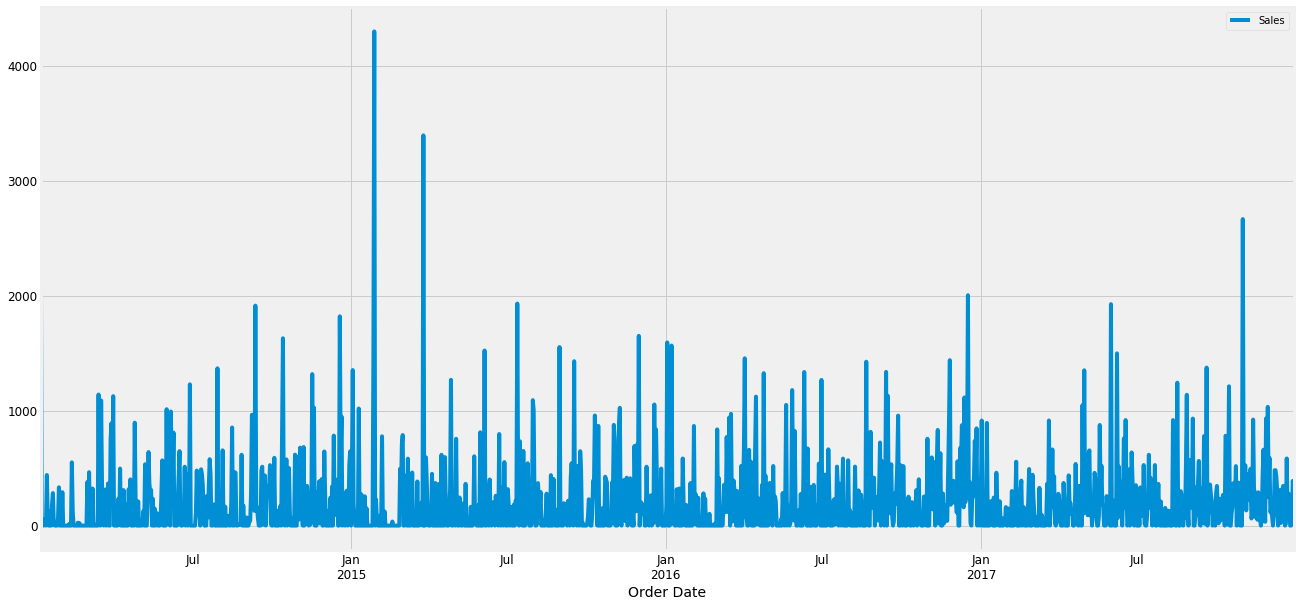

In [66]:
furniture_final.plot(figsize=(20, 10))
plt.show()

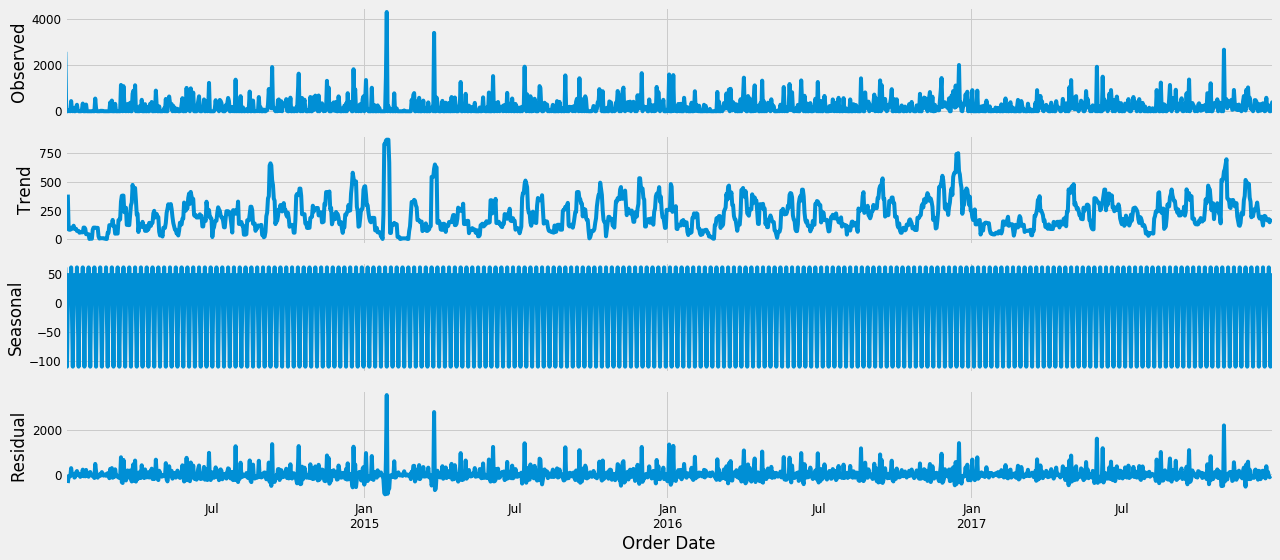

In [70]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(
    furniture_final,
    model='additive'
)
fig = decomposition.plot()
plt.show()

#### Monthly data

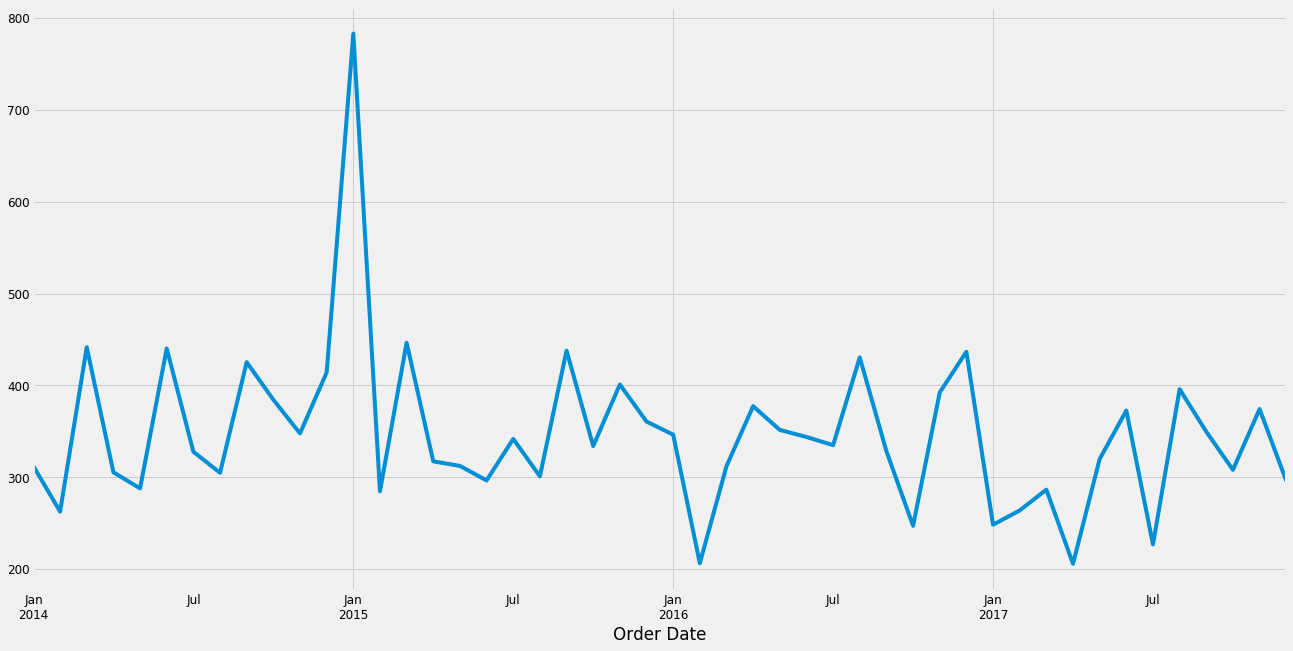

In [83]:
furniture_agg.plot(figsize=(20, 10))
plt.show()

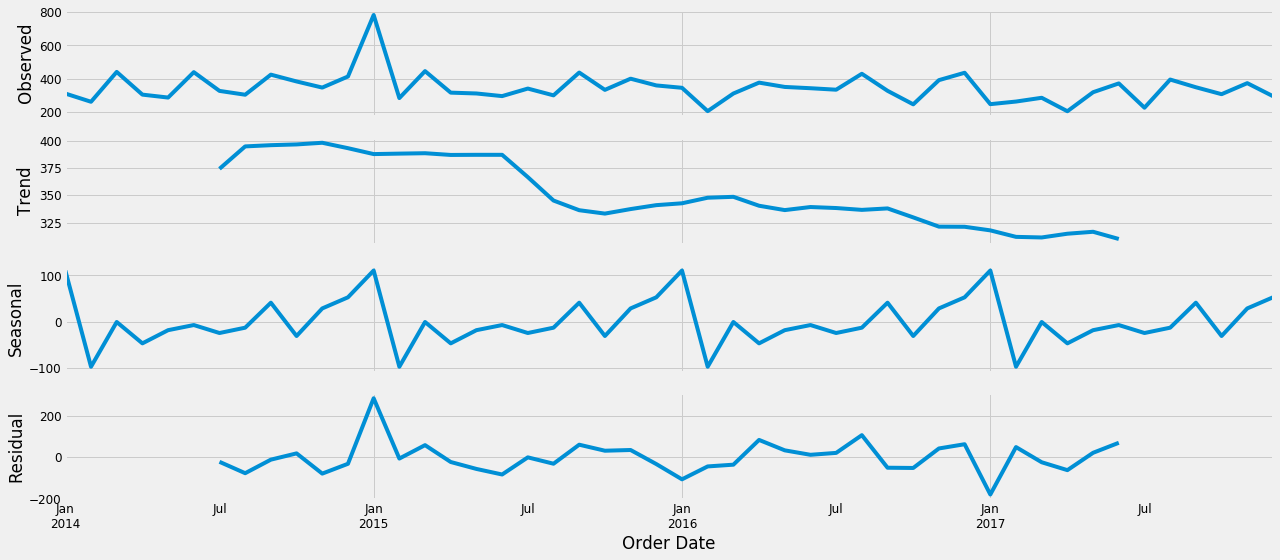

In [84]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(
    furniture_agg,
    model='additive'
)
fig = decomposition.plot()
plt.show()

## Modeling With ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, the ARIMA model, which stands for Autoregressive Integrated Moving Average

#### Daily Data

In [113]:
# Let's use Grid Search to help us find the optimal set of parameters. We will assess the
# combinations using the AIC measure.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm\
            .tsa\
            .statespace.\
            SARIMAX(
                furniture_final,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(
                param,
                param_seasonal,
                results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:21548.27439616101
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:21310.546384985213
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:21926.430891265314
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:20801.68987964724
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:21291.293431230748
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:20977.489318051557
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:21325.620809796095
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:20803.429533043272
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:21441.30574040161
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:21235.432441033525
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:21913.24273054651
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:20788.082157457604
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:21247.497355013227
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:21009.305980869314
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:21327.355386144925
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:20789.780185158983
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:22022.276720391965
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:21852.206613673

In [75]:
# Fitting the ARIMA model
daily_mod = sm.tsa.statespace.SARIMAX(
    furniture_final,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
daily_results = daily_mod.fit()
print(daily_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0347      0.021      1.633      0.102      -0.007       0.076
ma.L1         -1.0000      0.026    -39.161      0.000      -1.050      -0.950
ar.S.L12      -0.0166      0.029     -0.565      0.572      -0.074       0.041
ma.S.L12      -1.0125      0.017    -60.623      0.000      -1.045      -0.980
sigma2       1.15e+05   2.22e-07   5.18e+11      0.000    1.15e+05    1.15e+05


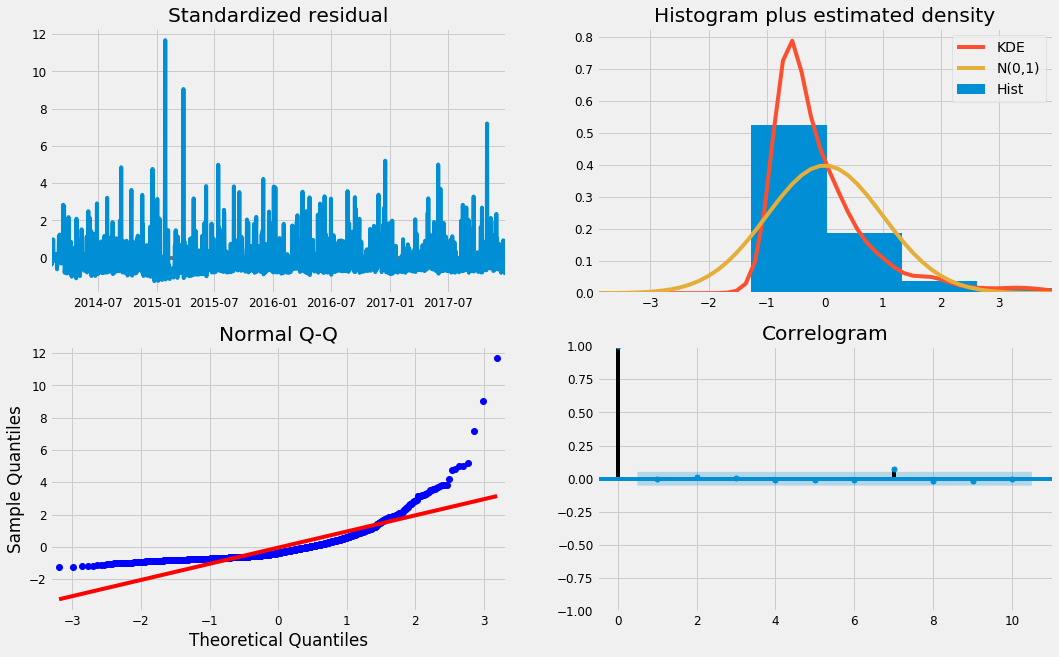

In [76]:
# Run model diagnostics to investigate any unusual behavior
daily_results.plot_diagnostics(figsize=(16, 10))
plt.show()

This model's rediduals do not look good. There is evidence of non-normality here. Let's pivot and use the aggrated data to see if we get better results.

#### Montly Data

In [95]:
# Let's use Grid Search to help us find the optimal set of parameters. We will assess the
# combinations using the AIC measure.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm\
            .tsa\
            .statespace\
            .SARIMAX(
                furniture_agg,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(
                param,
                param_seasonal,
                results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1447.3867340897314
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.20464898591723
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501692
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1317.6576376825706
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.446456472235
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.124068066613
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3179.1590875170373
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.5496453364607
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.1449552702865
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2580.6590859682783
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.44640662502366
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.6389269668506
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1368.3702584714238
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:433.35521367147123
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:437.46040107889746
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1745.5126161106734
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:294.1158452476943
AR

In [96]:
# Fitting the ARIMA model
monthly_mod = sm.tsa.statespace.SARIMAX(
    furniture_agg,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
monthly_results = monthly_mod.fit()
print(monthly_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0771      0.259     -0.298      0.766      -0.584       0.430
ma.L1         -1.0000      0.434     -2.305      0.021      -1.850      -0.150
ar.S.L12      -0.0007      0.029     -0.025      0.980      -0.057       0.056
sigma2      6323.9741   6.86e-05   9.22e+07      0.000    6323.974    6323.974


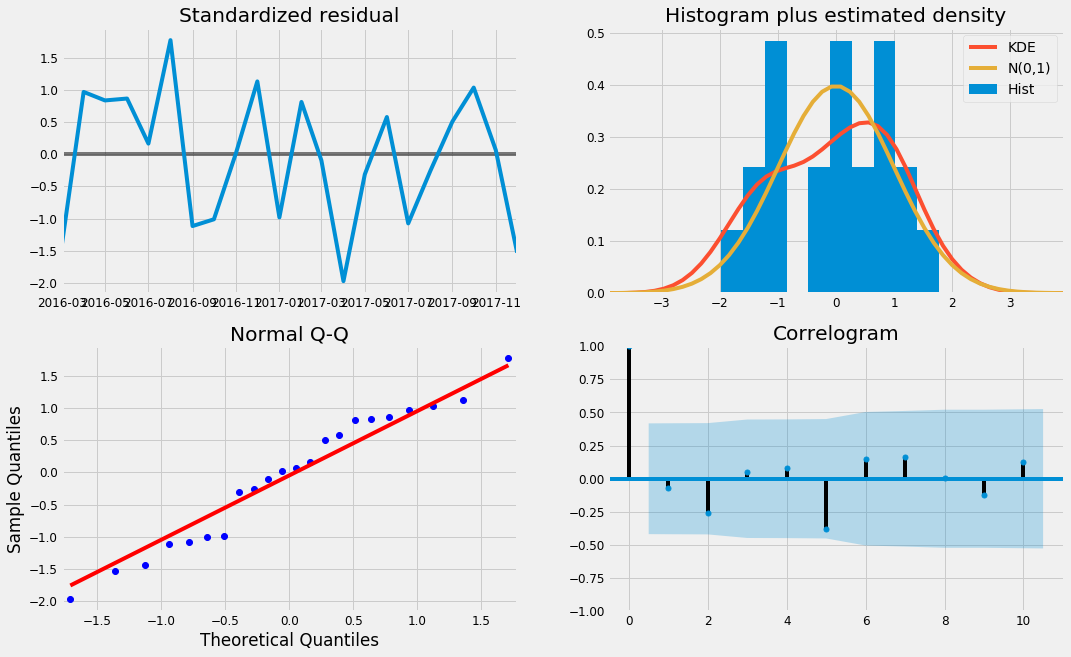

In [97]:
# Run model diagnostics to investigate any unusual behavior
monthly_results.plot_diagnostics(figsize=(16, 10))
plt.show()

The residuals look much better here. Our model diagnostics suggests that the model residuals are near normally distributed.

### Validating forecasts
 Now that we have an ok model, let's try to use it to forcast into the future. Validating our model will help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series. We set forecasts to start at 2017–01–01 which is the ending date of our data.

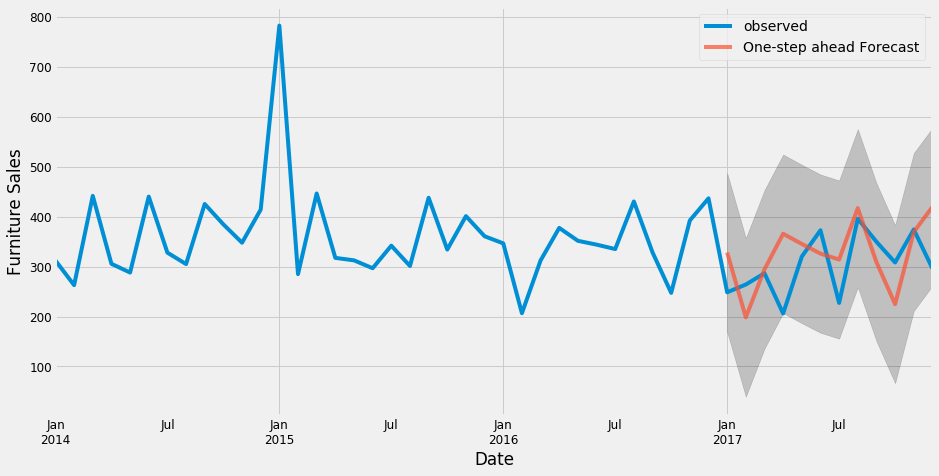

In [98]:
pred = results.get_prediction(
    start=pd.to_datetime('2017-01-01'),
    dynamic=False
)
pred_ci = pred.conf_int()
ax = furniture_agg['2014':].plot(label='observed')
pred.predicted_mean.plot(
    ax=ax,
    label='One-step ahead Forecast',
    alpha=.7,
    figsize=(14, 7)
)
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=.2
)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [101]:
forecasted = pred.predicted_mean
truth = furniture_agg['2017-01-01':]
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 5911.26
The Root Mean Squared Error of our forecasts is 76.88


##### MSE & RMSE
The mean squared error (MSE) of an estimator measures the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 76.88 of the real sales. Our furniture daily sales range from around 1.89 to over 4416.17. In my opinion, this is a pretty good model so far.

### Producing and visualizing forecasts

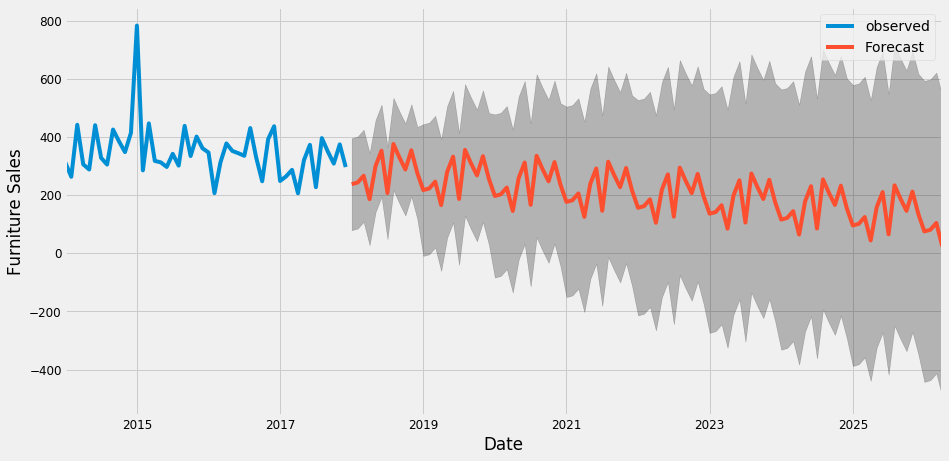

In [109]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = furniture_agg.plot(
    label='observed',
    figsize=(
        14,
        7
    )
)
pred_uc.predicted_mean.plot(
    ax=ax,
    label='Forecast'
)
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=.25
)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Forecasting Office Supplies Sales

In [114]:
office_supplies = df.loc[df['Category'] == 'Office Supplies']

In [115]:
print(office_supplies['Order Date'].min(), office_supplies['Order Date'].max())

2014-01-03 00:00:00 2017-12-30 00:00:00


## Data Cleaning & Formatting
Here we will select only the variables that we need for this analysis, check for missing values, and then aggregate the sales by date or fill in missing days.

In [116]:
cols = [
    'Row ID',
    'Order ID',
    'Ship Date',
    'Ship Mode',
    'Customer ID',
    'Customer Name',
    'Segment',
    'Country',
    'City',
    'State',
    'Postal Code',
    'Region', 
    'Product ID',
    'Category',
    'Sub-Category',
    'Product Name',
    'Quantity',
    'Discount',
    'Profit',
]

office_supplies.drop(
    cols,
    axis=1,
    inplace=True
)
office_supplies = office_supplies.sort_values('Order Date')

In [117]:
office_supplies.head(3)

,Order Date,Sales
7980,2014-01-03,16.448
740,2014-01-04,272.736
739,2014-01-04,11.784


In [118]:
# Check for missing values
office_supplies.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [119]:
office_supplies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6026 entries, 7980 to 645
Data columns (total 2 columns):
Order Date    6026 non-null datetime64[ns]
Sales         6026 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 141.2 KB


In [120]:
print(office_supplies['Sales'].min(), office_supplies['Sales'].max())

0.44399999999999995 9892.74


In [121]:
# We have some missing days in our data. We could either aggregate each month together and
# use the start of each month as the timestamp. We could also use a Pandas method to fill
# in all of the missing days. For this example we will use the pandas method to fill
# in all of the missings days.

# Filling in Dates
office_supplies_daily = office_supplies.set_index('Order Date')
office_supplies_daily = office_supplies_daily.resample('D').mean()
office_supplies_daily = office_supplies_daily.fillna(0)

# Aggregating by month
office_supplies_monthly = office_supplies.set_index('Order Date')
office_supplies_monthly = office_supplies_monthly['Sales'].resample('MS').mean()

In [123]:
# Sanity check
office_supplies_daily.tail(3)
# office_supplies_monthly.head(3)

,Sales
Order Date,
2017-12-28,90.9370
2017-12-29,56.4880
2017-12-30,59.9448


## EDA

##### Daily Data

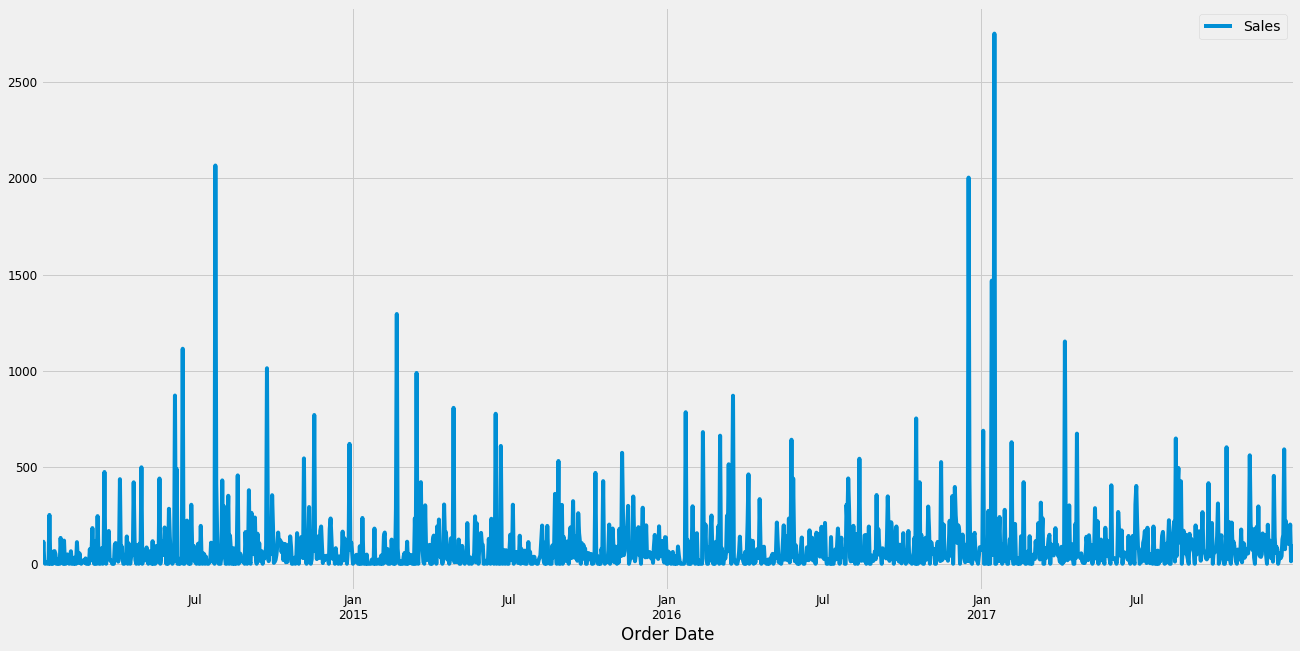

In [124]:
office_supplies_daily.plot(figsize=(20, 10))
plt.show()

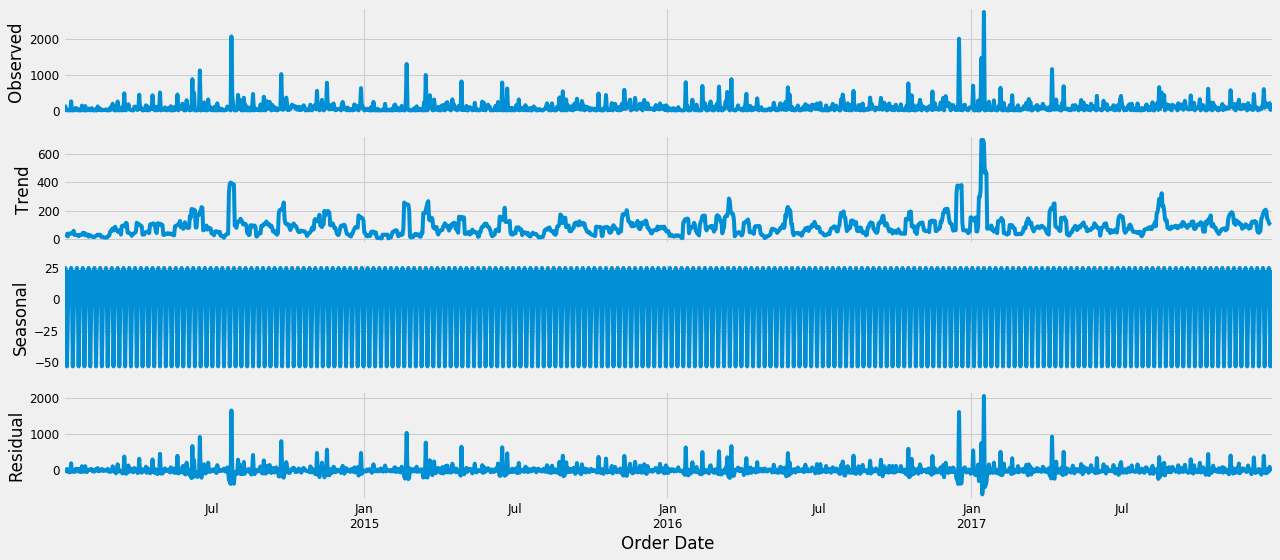

In [125]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(
    office_supplies_daily,
    model='additive'
)
fig = decomposition.plot()
plt.show()

#### Monthly data

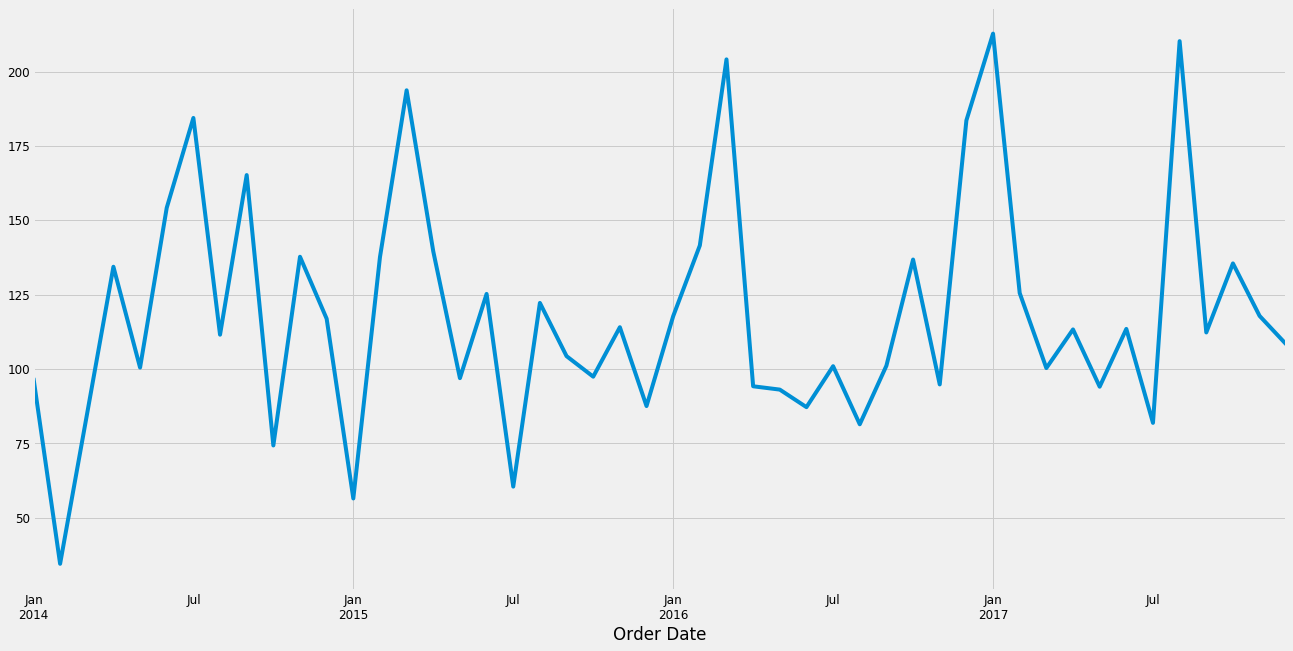

In [126]:
office_supplies_monthly.plot(figsize=(20, 10))
plt.show()

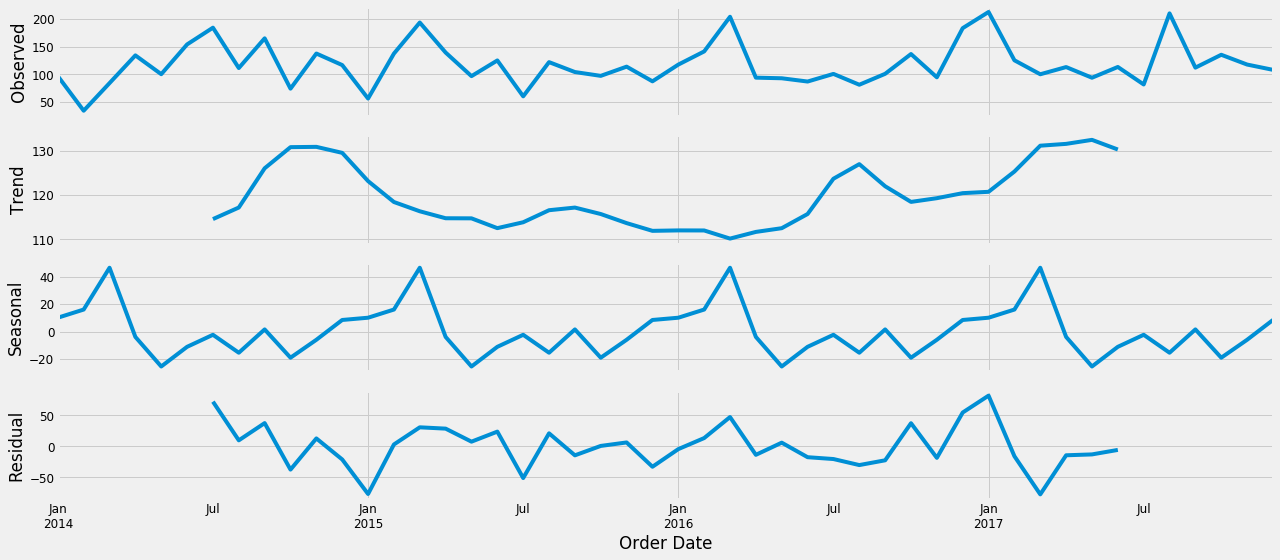

In [127]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(
    office_supplies_monthly,
    model='additive'
)
fig = decomposition.plot()
plt.show()

## Modeling With ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, the ARIMA model, which stands for Autoregressive Integrated Moving Average

#### Daily Data

In [128]:
# Let's use Grid Search to help us find the optimal set of parameters. We will assess the
# combinations using the AIC measure.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm\
            .tsa\
            .statespace.\
            SARIMAX(
                office_supplies_daily,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(
                param,
                param_seasonal,
                results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:19447.854373949252
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:19246.65729283847
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:19939.83099887966
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:18839.654692318934
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:19242.052310746498
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:18997.66211759077
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:19407.1229262704
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:18841.63553572495
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:19359.735627617214
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:19181.150573407293
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:19925.39570677057
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:18825.824480420233
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:19198.00524460861
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:19010.980669682096
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:19405.316324191877
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:18827.80589550156
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:20012.33946414713
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:19858.53774138108
ARI

In [129]:
# Fitting the ARIMA model
daily_mod = sm.tsa.statespace.SARIMAX(
    office_supplies_daily,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
daily_results = daily_mod.fit()
print(daily_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0465      0.026      1.792      0.073      -0.004       0.097
ma.L1         -1.0000      1.600     -0.625      0.532      -4.136       2.136
ma.S.L12      -1.0000      1.607     -0.622      0.534      -4.150       2.150
sigma2      2.877e+04   5.77e-05   4.99e+08      0.000    2.88e+04    2.88e+04


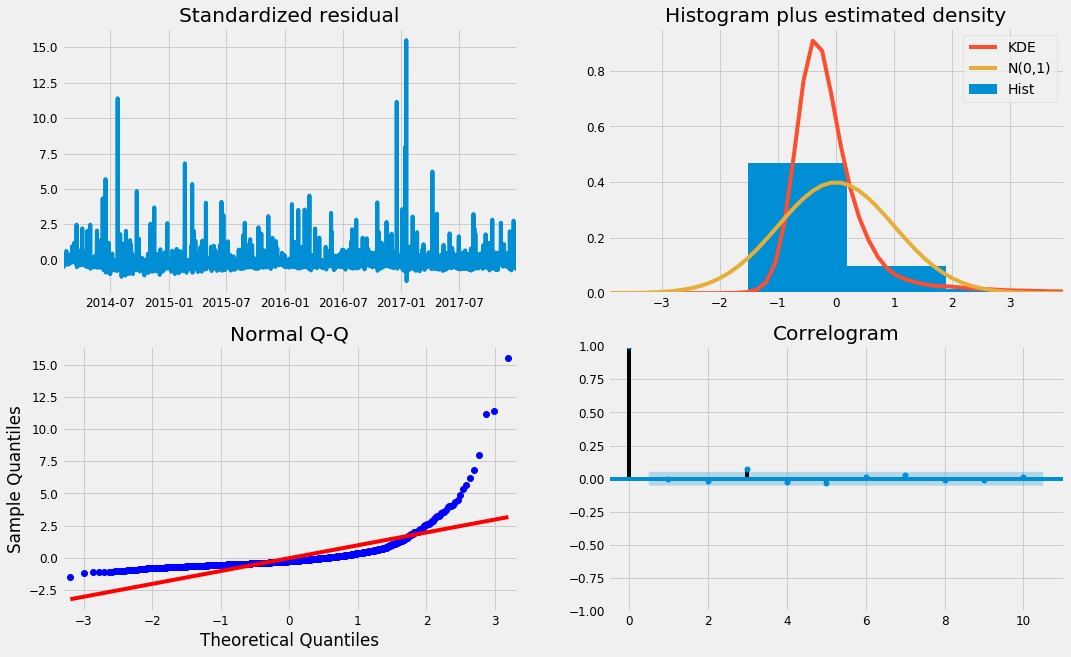

In [130]:
# Run model diagnostics to investigate any unusual behavior
daily_results.plot_diagnostics(figsize=(16, 10))
plt.show()

This model's rediduals do not look good. There is evidence of non-normality here. Let's pivot and use the aggrated data to see if we get better results.

#### Montly Data

In [131]:
# Let's use Grid Search to help us find the optimal set of parameters. We will assess the
# combinations using the AIC measure.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm\
            .tsa\
            .statespace\
            .SARIMAX(
                office_supplies_monthly,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(
                param,
                param_seasonal,
                results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:589.5002315061224
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1591.5435548121225
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:383.4175511140882
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:394.8386791980883
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1659.187602868842
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:260.5044719309093
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:545.8315751699364
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2689.226275000322
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:371.81948302766335
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:396.43734243158195
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2604.889031558135
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:262.1735163819378
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:496.8049609774629
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1416.1505444848817
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:391.41369839961806
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:378.31299876316575
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1150.02681121778
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:262.6969740305961
ARIMA

In [132]:
# Fitting the ARIMA model
monthly_mod = sm.tsa.statespace.SARIMAX(
    office_supplies_monthly,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
monthly_results = monthly_mod.fit()
print(monthly_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1114      0.352      0.316      0.752      -0.579       0.802
ma.L1         -1.0000      0.342     -2.923      0.003      -1.671      -0.330
ar.S.L12      -0.2542      0.286     -0.890      0.374      -0.814       0.306
sigma2      2704.3756      0.000   2.14e+07      0.000    2704.375    2704.376


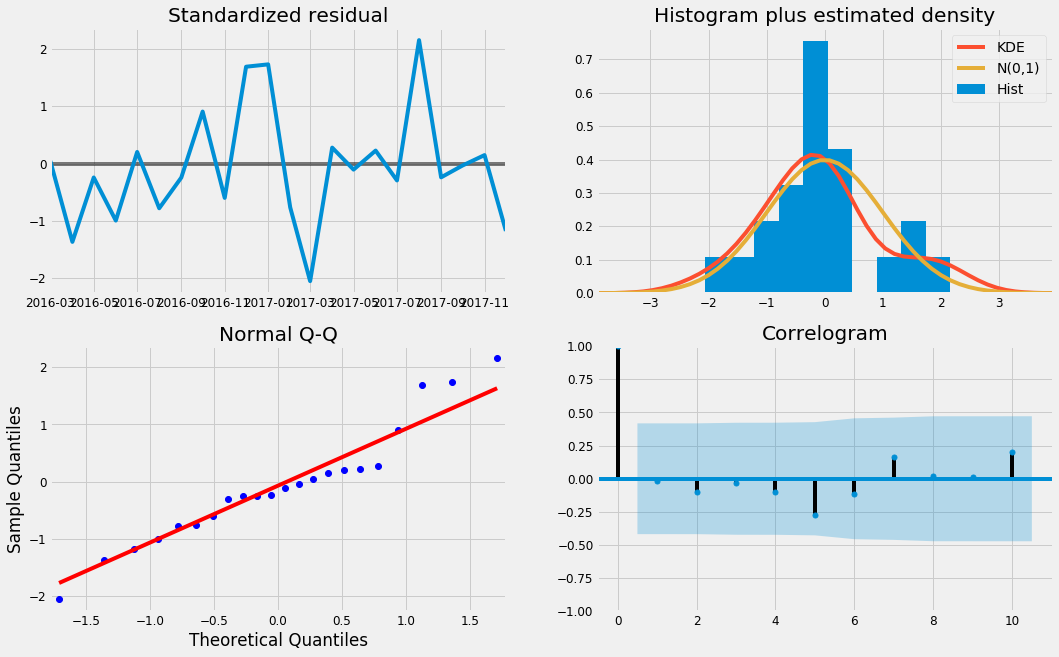

In [133]:
# Run model diagnostics to investigate any unusual behavior
monthly_results.plot_diagnostics(figsize=(16, 10))
plt.show()

The residuals look much better here. Our model diagnostics suggests that the model residuals are near normally distributed.

### Validating forecasts
 Now that we have an ok model, let's try to use it to forcast into the future. Validating our model will help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series. We set forecasts to start at 2017–01–01 which is the ending date of our data.

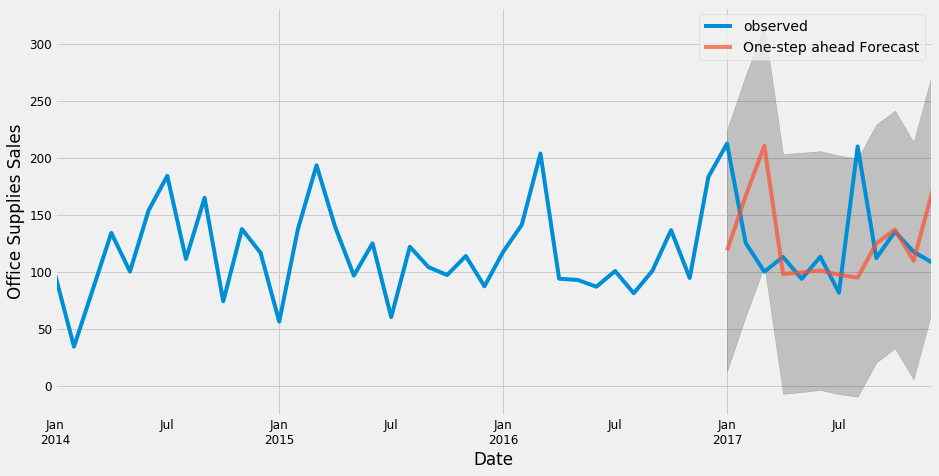

In [134]:
pred = results.get_prediction(
    start=pd.to_datetime('2017-01-01'),
    dynamic=False
)
pred_ci = pred.conf_int()
ax = office_supplies_monthly['2014':].plot(label='observed')
pred.predicted_mean.plot(
    ax=ax,
    label='One-step ahead Forecast',
    alpha=.7,
    figsize=(14, 7)
)
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=.2
)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

In [160]:
forecasted = pred.predicted_mean
truth = office_supplies_monthly['2017-01-01':]
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 168175.89
The Root Mean Squared Error of our forecasts is 410.09


##### MSE & RMSE
The mean squared error (MSE) of an estimator measures the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily office supplies sales in the test set within 410.09 of the real sales. Our office supplies daily sales range from around 0.44 to over 9892.74. In my opinion, this is a pretty good model so far.

### Producing and visualizing forecasts

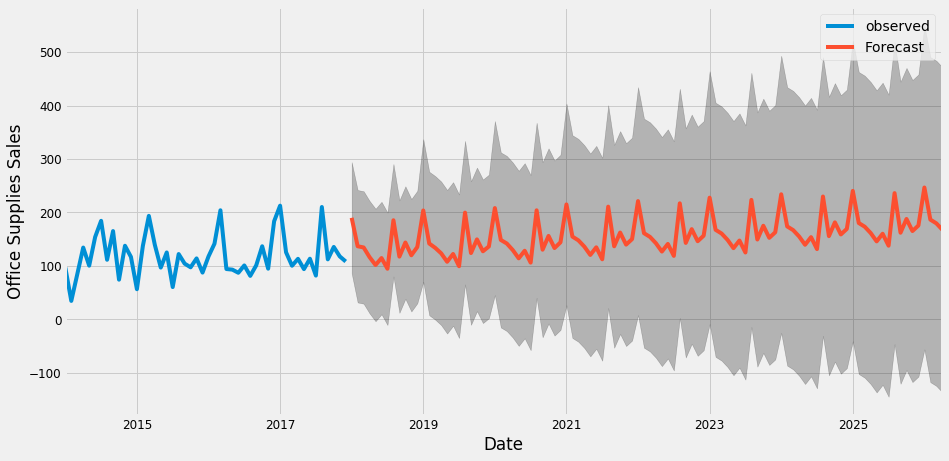

In [136]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = office_supplies_monthly.plot(
    label='observed',
    figsize=(
        14,
        7
    )
)
pred_uc.predicted_mean.plot(
    ax=ax,
    label='Forecast'
)
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=.25
)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

Our model clearly captured office supplies sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Forecasting Technology Sales

In [138]:
technology = df.loc[df['Category'] == 'Technology']

In [139]:
print(technology['Order Date'].min(), technology['Order Date'].max())

2014-01-06 00:00:00 2017-12-30 00:00:00


## Data Cleaning & Formatting
Here we will select only the variables that we need for this analysis, check for missing values, and then aggregate the sales by date or fill in missing days.

In [140]:
cols = [
    'Row ID',
    'Order ID',
    'Ship Date',
    'Ship Mode',
    'Customer ID',
    'Customer Name',
    'Segment',
    'Country',
    'City',
    'State',
    'Postal Code',
    'Region', 
    'Product ID',
    'Category',
    'Sub-Category',
    'Product Name',
    'Quantity',
    'Discount',
    'Profit',
]

technology.drop(
    cols,
    axis=1,
    inplace=True
)
technology = technology.sort_values('Order Date')

In [141]:
technology.head(3)

,Order Date,Sales
7478,2014-01-06,755.96
7477,2014-01-06,391.98
593,2014-01-09,31.20


In [142]:
# Check for missing values
technology.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [143]:
technology.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 7478 to 907
Data columns (total 2 columns):
Order Date    1847 non-null datetime64[ns]
Sales         1847 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 43.3 KB


In [144]:
print(technology['Sales'].min(), technology['Sales'].max())

0.99 22638.48


In [145]:
# We have some missing days in our data. We could either aggregate each month together and
# use the start of each month as the timestamp. We could also use a Pandas method to fill
# in all of the missing days. For this example we will use the pandas method to fill
# in all of the missings days.

# Filling in Dates
technology_daily = technology.set_index('Order Date')
technology_daily = technology_daily.resample('D').mean()
technology_daily = technology_daily.fillna(0)

# Aggregating by month
technology_monthly = technology.set_index('Order Date')
technology_monthly = technology_monthly['Sales'].resample('MS').mean()

In [146]:
# Sanity check
technology_daily.tail(3)
# technology_monthly.head(3)

,Sales
Order Date,
2017-12-28,14.850
2017-12-29,302.376
2017-12-30,90.930


## EDA

##### Daily Data

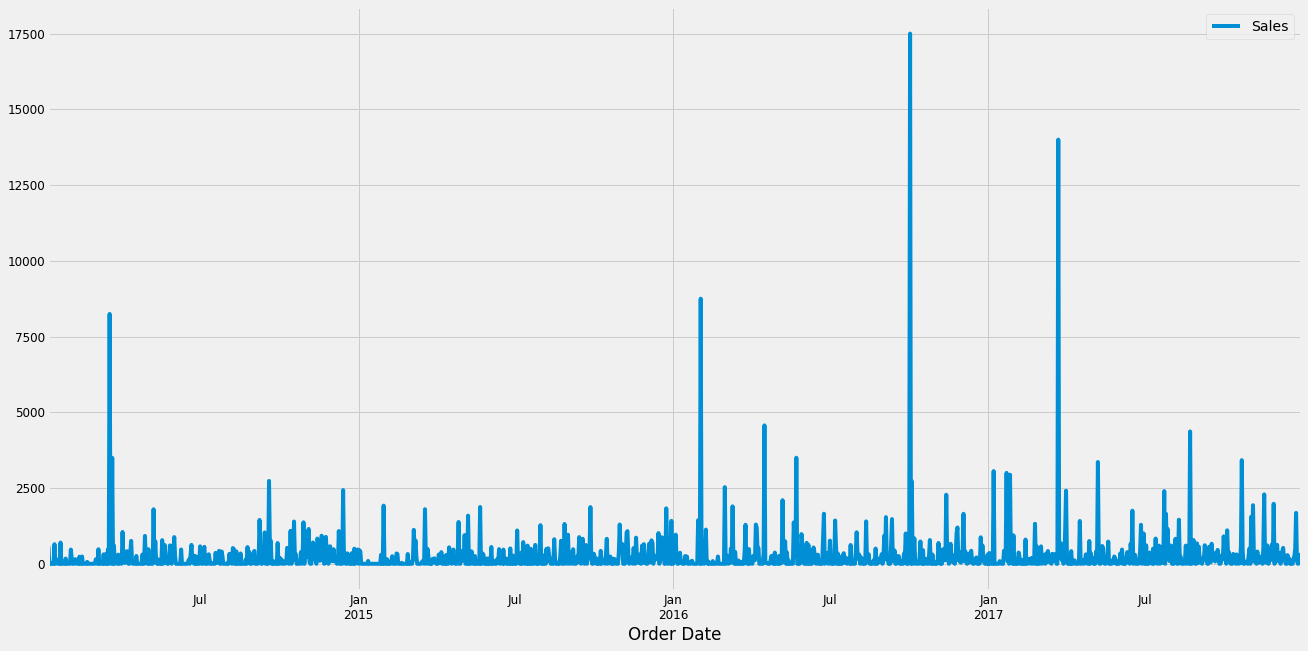

In [147]:
technology_daily.plot(figsize=(20, 10))
plt.show()

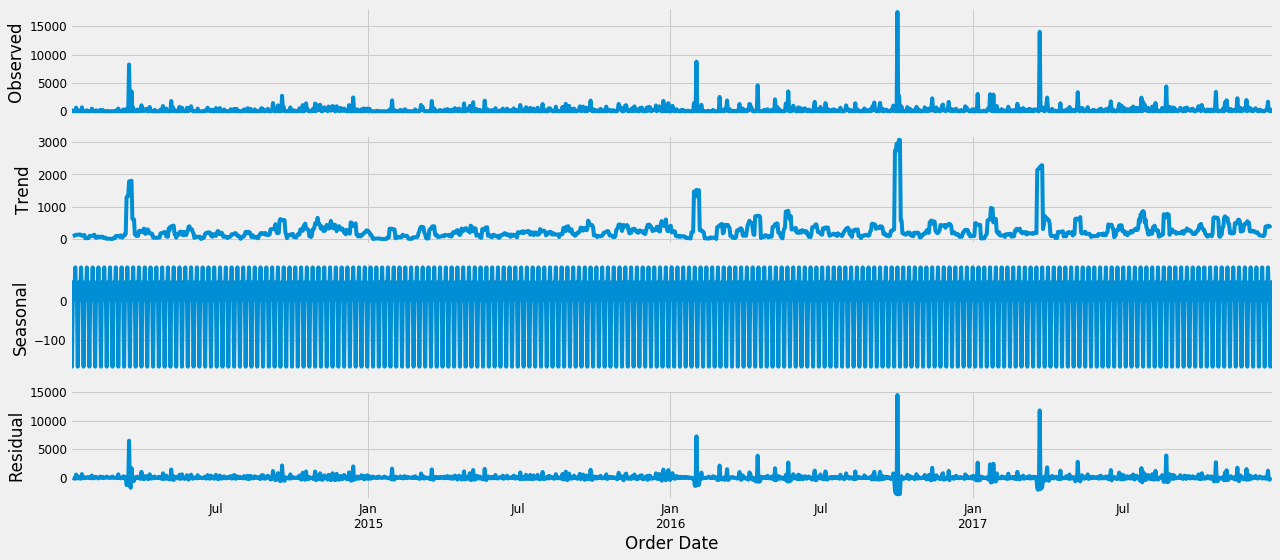

In [148]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(
    technology_daily,
    model='additive'
)
fig = decomposition.plot()
plt.show()

#### Monthly data

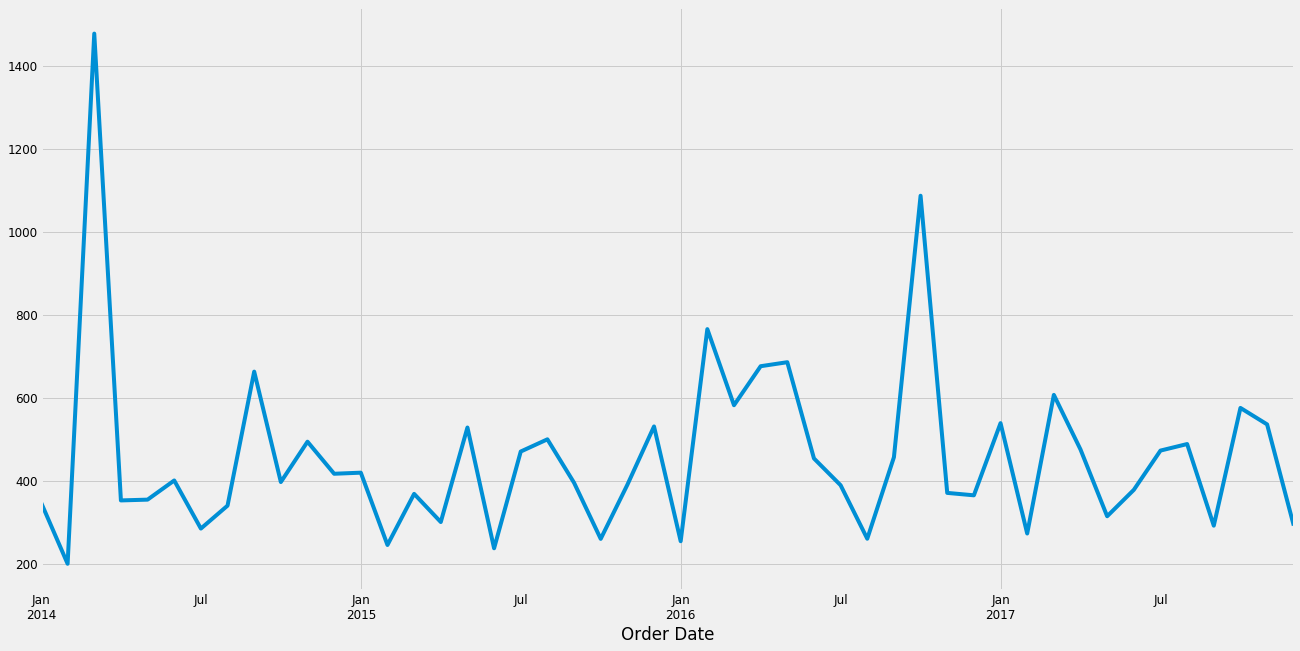

In [149]:
technology_monthly.plot(figsize=(20, 10))
plt.show()

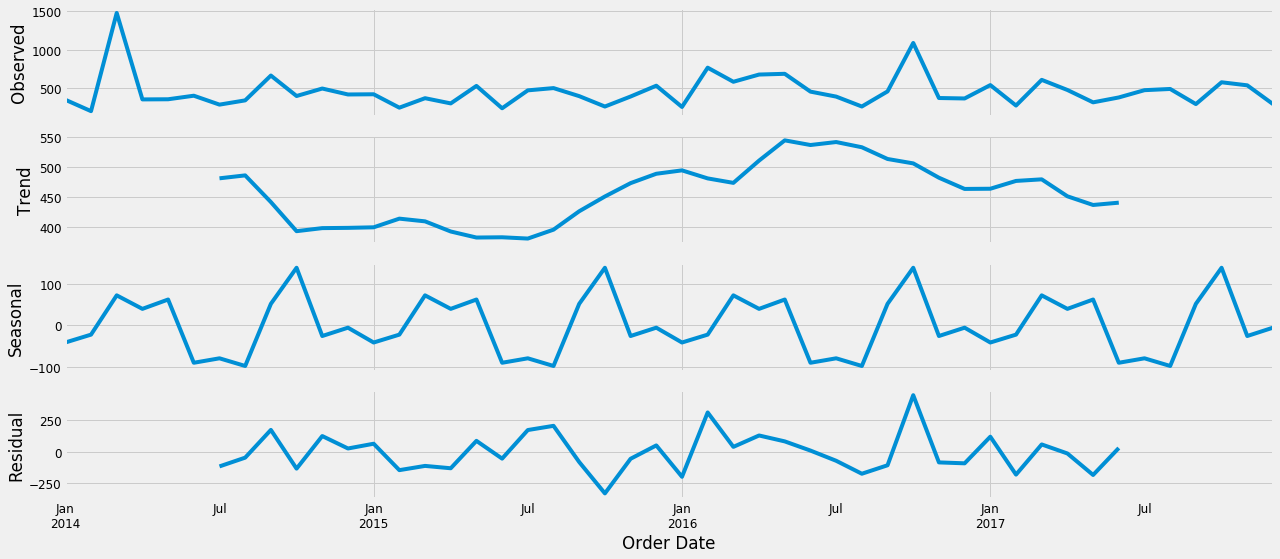

In [150]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(
    technology_monthly,
    model='additive'
)
fig = decomposition.plot()
plt.show()

## Modeling With ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, the ARIMA model, which stands for Autoregressive Integrated Moving Average

#### Daily Data

In [151]:
# Let's use Grid Search to help us find the optimal set of parameters. We will assess the
# combinations using the AIC measure.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm\
            .tsa\
            .statespace.\
            SARIMAX(
                technology_daily,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(
                param,
                param_seasonal,
                results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:23697.88403685814
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:23504.56506288005
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:24367.65781213047
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:23220.79773028106
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:23517.921052172038
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:23411.998114717837
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:23800.71658845587
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:23222.487267703687
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:23676.655652265
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:23485.246510389996
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:24353.436457851334
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:23207.00661562467
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:23514.701516958434
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:23401.68945211811
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:23802.47177529372
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:23208.674796983873
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:24565.043744069455
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:24375.638633138442
ARI

In [154]:
# Fitting the ARIMA model
daily_mod = sm.tsa.statespace.SARIMAX(
    technology_daily,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
daily_results = daily_mod.fit()
print(daily_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0227      0.088     -0.258      0.796      -0.195       0.150
ma.L1         -1.0000      0.036    -27.617      0.000      -1.071      -0.929
ma.S.L12      -1.0090      0.025    -40.341      0.000      -1.058      -0.960
sigma2      6.296e+05   5.76e-08   1.09e+13      0.000     6.3e+05     6.3e+05


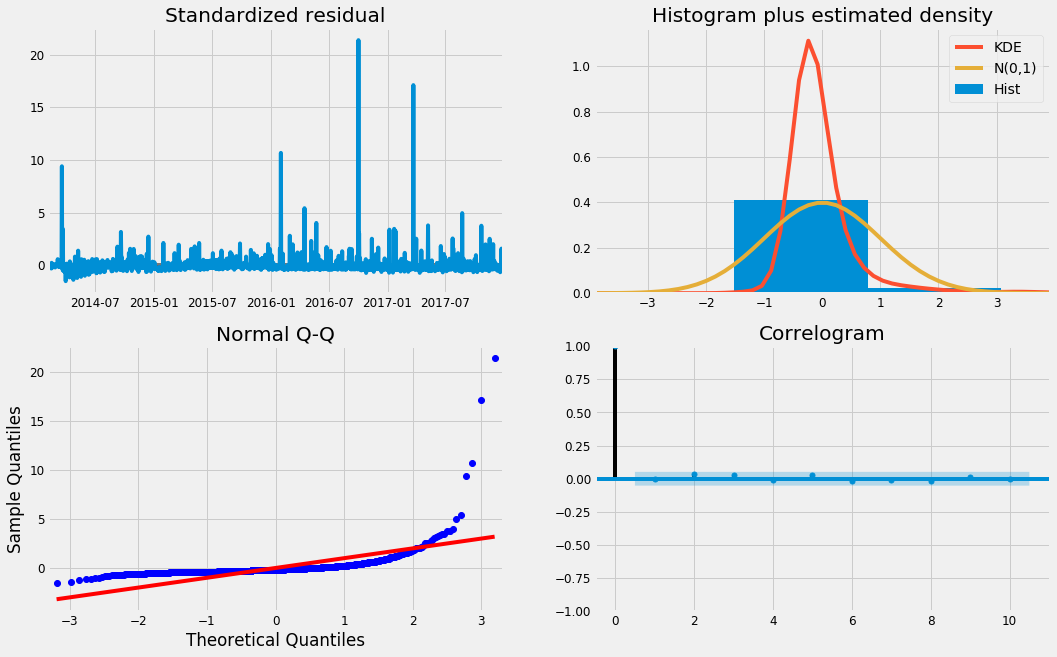

In [155]:
# Run model diagnostics to investigate any unusual behavior
daily_results.plot_diagnostics(figsize=(16, 10))
plt.show()

This model's rediduals do not look good. There is evidence of non-normality here. Let's pivot and use the aggrated data to see if we get better results.

#### Montly Data

In [156]:
# Let's use Grid Search to help us find the optimal set of parameters. We will assess the
# combinations using the AIC measure.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm\
            .tsa\
            .statespace\
            .SARIMAX(
                technology_monthly,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(
                param,
                param_seasonal,
                results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:721.5688506163442
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1055.5858054199712
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:506.0787430174984
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:514.1576203103061
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1472.7250854058714
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:337.72306528701387
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:683.3203705205253
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:494.6399962665433
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:514.2823881454731
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:18682142.027006976
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:336.0872353360354
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:668.304572130738
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1210.0356200609585
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:515.9044562019011
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:489.2638159231583
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1359.4815994097617
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:345.5369970527209
ARIMA(0, 1, 1)x(0, 

In [157]:
# Fitting the ARIMA model
monthly_mod = sm.tsa.statespace.SARIMAX(
    technology_monthly,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
monthly_results = monthly_mod.fit()
print(monthly_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3906      0.299     -1.308      0.191      -0.976       0.195
ma.L1         -1.1081      0.362     -3.058      0.002      -1.818      -0.398
ar.S.L12      -0.5905      0.119     -4.958      0.000      -0.824      -0.357
sigma2      4.377e+04   2.16e+04      2.029      0.042    1482.763     8.6e+04


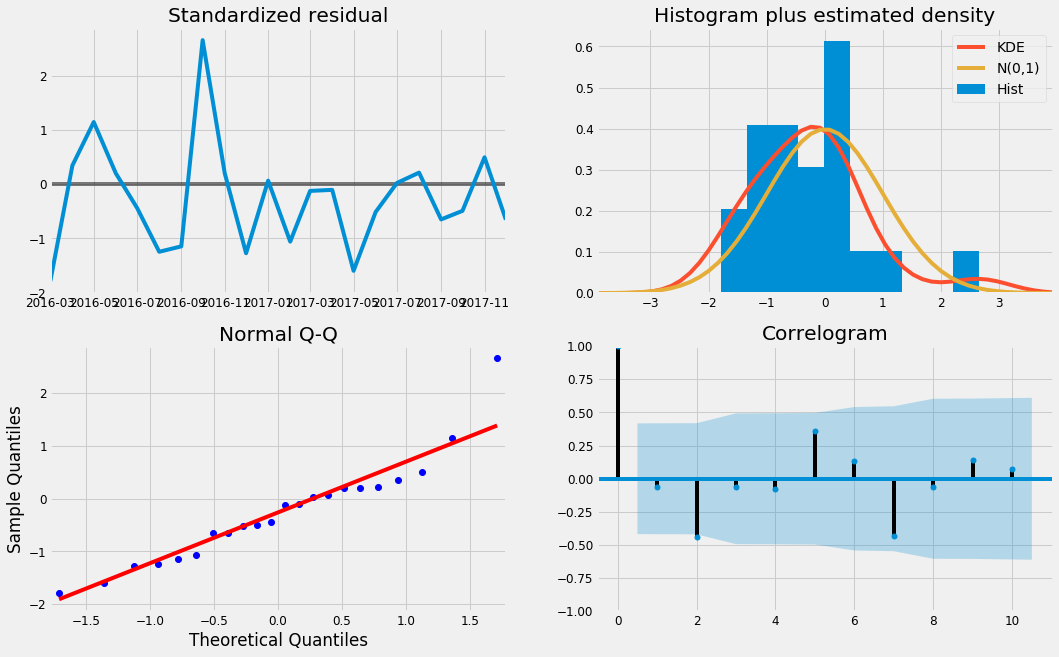

In [158]:
# Run model diagnostics to investigate any unusual behavior
monthly_results.plot_diagnostics(figsize=(16, 10))
plt.show()

The residuals look much better here. Our model diagnostics suggests that the model residuals are near normally distributed.

### Validating forecasts
 Now that we have an ok model, let's try to use it to forcast into the future. Validating our model will help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series. We set forecasts to start at 2017–01–01 which is the ending date of our data.

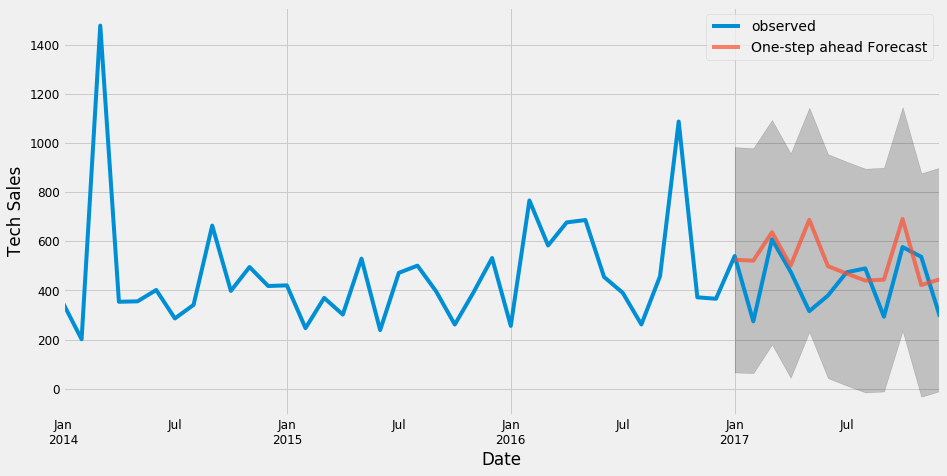

In [159]:
pred = results.get_prediction(
    start=pd.to_datetime('2017-01-01'),
    dynamic=False
)
pred_ci = pred.conf_int()
ax = technology_monthly['2014':].plot(label='observed')
pred.predicted_mean.plot(
    ax=ax,
    label='One-step ahead Forecast',
    alpha=.7,
    figsize=(14, 7)
)
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=.2
)
ax.set_xlabel('Date')
ax.set_ylabel('Tech Sales')
plt.legend()
plt.show()

In [161]:
forecasted = pred.predicted_mean
truth = technology_monthly['2017-01-01':]
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 24151.23
The Root Mean Squared Error of our forecasts is 155.41


##### MSE & RMSE
The mean squared error (MSE) of an estimator measures the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily technology sales in the test set within 155.41 of the real sales. Our technology daily sales range from around 0.99 to over 22638. In my opinion, this is a pretty good model so far.

### Producing and visualizing forecasts

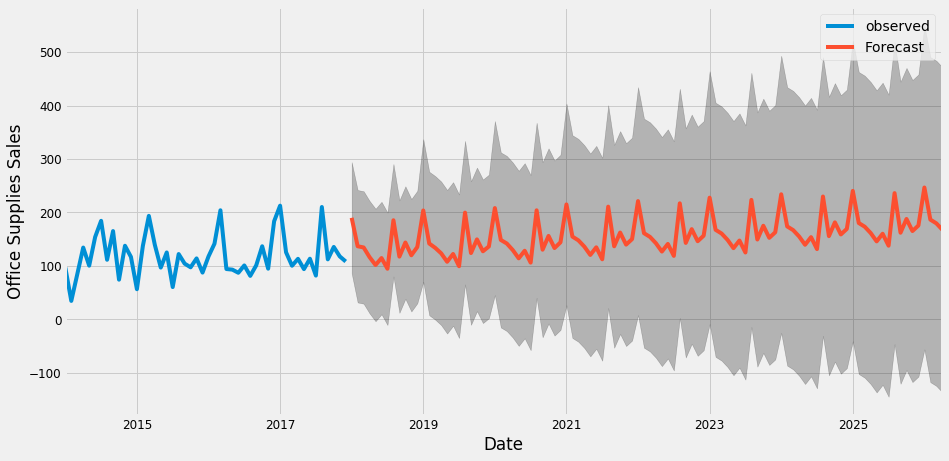

In [136]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = office_supplies_monthly.plot(
    label='observed',
    figsize=(
        14,
        7
    )
)
pred_uc.predicted_mean.plot(
    ax=ax,
    label='Forecast'
)
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=.25
)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

Our model clearly captured technology sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

# Time Series of Furniture vs. Office Supplies vs. Technology 

In [170]:
technology_monthly = pd.DataFrame(technology_monthly).reset_index()
office_supplies_monthly = pd.DataFrame(office_supplies_monthly).reset_index()
furniture_monthly = pd.DataFrame(furniture_agg).reset_index()

In [175]:
# Furniture and Office Supplies
furniture_office_supplies = furniture_monthly.merge(
    office_supplies_monthly,
    how='inner',
    on='Order Date'
)
furniture_office_supplies.rename(
    columns={
        'Sales_x': 'furniture_sales',
        'Sales_y': 'office_sales'
    },
    inplace=True
)
# Furniture/Office Supplies into tech
store = furniture_office_supplies.merge(
    technology_monthly,
    how='inner',
    on='Order Date'
)
store.rename(
    columns={
        "Sales": "tech_sales"
    },
    inplace=True
)
store = store[['Order Date', 'furniture_sales', 'office_sales', 'tech_sales']]
store.head()

,Order Date,furniture_sales,office_sales,tech_sales
0,2014-01-01,312.126250,97.021600,349.254444
1,2014-02-01,262.808286,34.571742,201.063750
2,2014-03-01,441.635030,84.371363,1477.780636
3,2014-04-01,305.570654,134.398482,353.670538
4,2014-05-01,288.032792,100.501746,355.550963


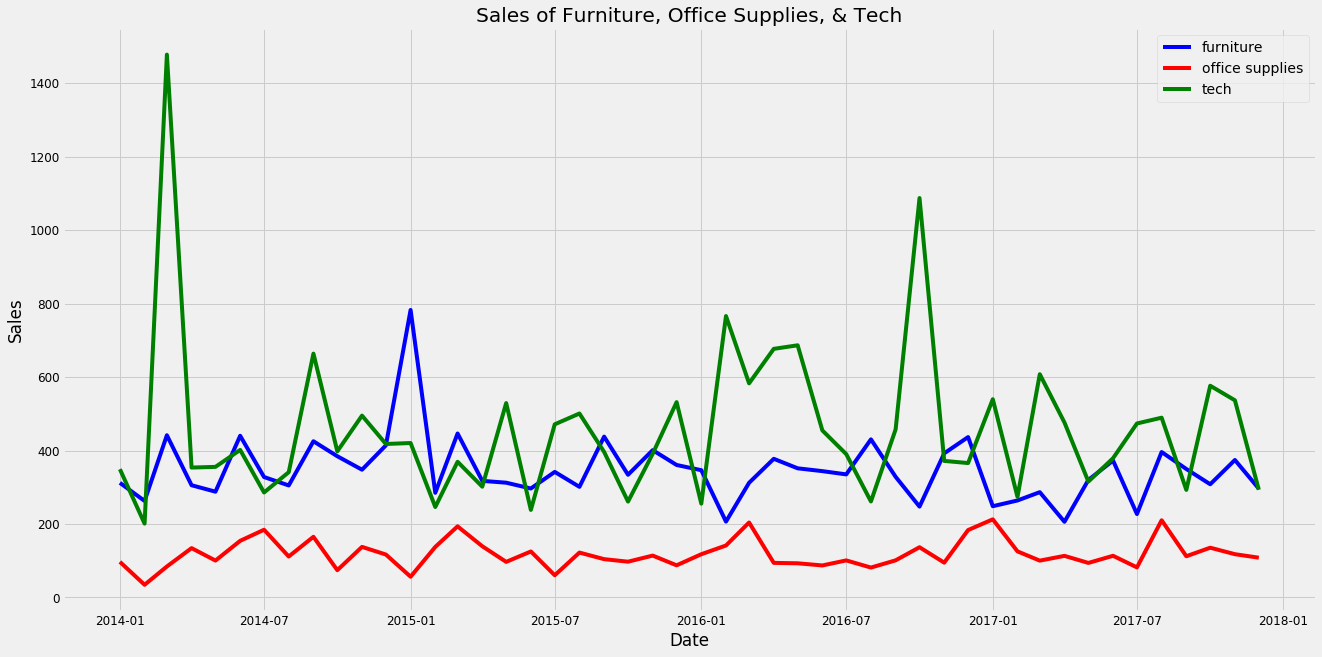

In [178]:
plt.figure(figsize=(20, 10))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.plot(store['Order Date'], store['tech_sales'], 'g-', label = 'tech')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of Furniture, Office Supplies, & Tech')
plt.legend()

# To be Continued